### Load mnist dataset

In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

/Users/jcoscolla/tmp/autoencoder/python/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# normalize between 0..1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

### Load the model

In [ ]:
from keras.models import load_model

autoencoder = load_model('autoencoder.h5')

### Create the model

In [3]:
## Create the model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
## encoded dim is 4x4x2

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

encoder = Model(input_img, encoded)
autoencoder = Model(input_img, decoded)



In [4]:
# !tensorboard --logdir=/tmp/autoencoder &

In [5]:
## Compile
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

## Train
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=3,
                batch_size=512,
                shuffle=True,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')],
                validation_data=(x_test, x_test))

autoencoder.save('autoencoder.h5')

Instructions for updating:
Use the retry module or similar alternatives.
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 38s 641us/step - loss: 0.2869 - val_loss: 0.2233
Epoch 2/3
60000/60000 [==============================] - 38s 640us/step - loss: 0.2049 - val_loss: 0.1842
Epoch 3/3
60000/60000 [==============================] - 39s 642us/step - loss: 0.1812 - val_loss: 0.1754


## Show some images 

First row is the original
Second row is the auto-decoded

In [6]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

/Users/jcoscolla/tmp/autoencoder/python/venv/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 2000x400 with 19 Axes>

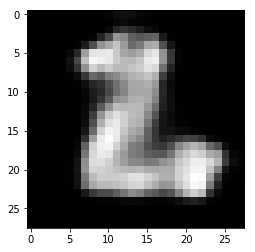

In [7]:
image = x_test[1]

image = np.expand_dims(image, axis=0)
decoded = autoencoder.predict(image)
#encoded_img = encoder.predict(image)

#print(encoded_img)

def show_image(image, shape = (28,28)):
    plt.imshow(image.reshape(shape[0], shape[1]))

show_image(image)
show_image(decoded)


In [8]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(autoencoder, 'model/')
